___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

Time series ile çalışırken önemli olan date indekse almak.

In [2]:
pwd

'C:\\Users\\HP\\DATA_SCIENCE_COURSE_NOTES\\2. Classes_Lab\\8. DeepLearning'

In [3]:
df = pd.read_csv('../8. DeepLearning/RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

Yukarıdaki parametrelerden index_col ile parse_dates çalıştırmazsak;	
    DATE	    RSCCASN
0	1992-01-01	6938
1	1992-02-01	7524   şeklinden bir sonuç veriyor.

0   DATE     334 non-null    object gösteriyor.

Eğer bu parametreleri çalıştırırsak;

DATE indekse alır.

Time Series de önemli olan DATE indekse almak, bunu yaparken de en kolayı dosyayı okurken önce date datetime çevirmek ve indekse atmaktır.

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns = ['Sales']  #column ismini değiştirdik.

<AxesSubplot:xlabel='DATE'>

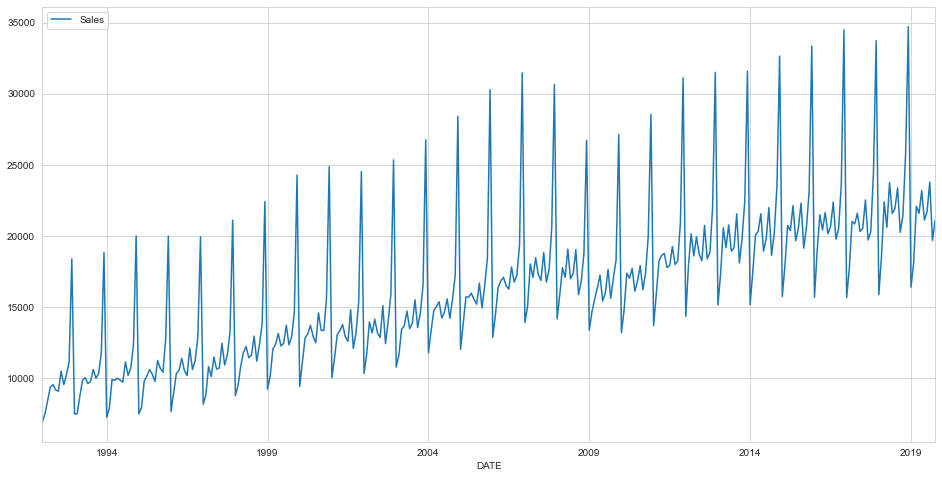

In [7]:
df.plot(figsize=(16,8))

Baktığımızda 2008-2009 yıllarında global bir kriz vardı. Bu dönemde satışlarda düşüş söz konusu olmuş.

Burada zaman ile satış arasındaki ilişkiden kaynaklı ileriye yönelik bir forecast yapıyoruz.

## Preprocessing of Data

### Train Test Split

12 veride bir benim modelim cycle döndürüyor. 

test_size burada benim bu cycle dan daha büyük almam gerekir. Burada 2 katı aldık.

Time series sequence olduğundan sıra önemli olduğundan random olarak bölünmemesi gerekir.

In [8]:
len(df)

334

In [9]:
test_size = 24

In [10]:
test_ind = len(df)- test_size
test_ind  # buradan itibaren datayı böleceğiz.

310

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [13]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

Burada tek univariate data ile çalıştığımızdan dolayı hepsi tek bir datanın içinde.

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

Küçük data setlerinde batchsize 1 seçtik. Time serieslerde fayda sağlıyor.

Shuffle burada default olarak False. Çünkü düzgün bir sıra ile oluşturulması yani karıştırılmaması isteniyor. ANN ve CNN shuffle default True du.

In [19]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [20]:
len(generator)  # 310-12/1*1 yaparak bu sonucu buldu. Yani 12 alıyor 13. tahmin ediyor.

298

In [21]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
train_scaled.shape  # satır ve feature sayısını verir.

(310, 1)

In [26]:
n_features = train_scaled.shape[1] # feature sayısını elle yazmak yerine bu şekilde yazdık.

Multivariate Time serieslarde de çalışırken yukarıdaki gibi n_features belirtirsek artık kaç yazacağım diye uğraşmayız.

return_sequences kullanma sebebimiz arka arkaya 2 tane RNN koyacaksam bir sonrakine de aynı datayı göndersin diye bu şekilde veriyoruz. Normalde 12 lük periyotta 12 data ile 13. tahmin ediyor. Ancak biz bunu tek layerda değilde sonrasında bir layer daha getireceksek bu layera tek bir output gelmesi yerine önceki yapıda kullanıldığı şekilde 12 li data gelmesi için yazıyoruz. 

Yani bir sonraki LSTM tek bir çıktı yerine ilkinde kullanılan yapıda datayı gönderecek bu şekilde.

return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: `False`.

LSTM de act.func. default tanh dır.

In [27]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1)) # output
model.compile(optimizer = 'adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [30]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [33]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [34]:
len(validation_generator)

12

In [35]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 4s 8ms/step - loss: 0.0255 - val_loss: 0.0298
Epoch 2/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0195 - val_loss: 0.0323
Epoch 3/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0196 - val_loss: 0.0472
Epoch 4/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0180 - val_loss: 0.0270
Epoch 5/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0167 - val_loss: 0.0244
Epoch 6/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0146 - val_loss: 0.0334
Epoch 7/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0155 - val_loss: 0.0222
Epoch 8/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0140 - val_loss: 0.0219
Epoch 9/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0136 - val_loss: 0.0200
Epoch 10/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0124 - val_loss: 0.0171

<AxesSubplot:>

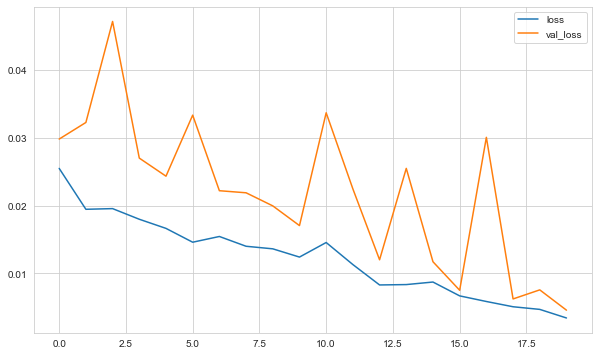

In [36]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

!!! Önemli:

train setimin sonundan length kadar kısmı alıyorum ve bunun üzerinden bir tahmin yapıyorum. Bunu kaydırarak predictionlar üzerinden forecast yapıyorum. Ve bunları boş bir liste atıyorum aşağıdaki gibi.

Generator benim 2 boyutlu datamı 3 boyuta çıkarmıştı. Bundan dolayı burada 1 boyut artırmam gerekir. Ve ismine current batch diyoruz.

Daha sonra current batch üzerinden tahmin alıyorum. Tahminim sonucu 2 boyutlu bir array çıktığından dolayı burada current_pred[0] ile indeksleme yaparak tek boyuta indirdim. Sequence bir kaydırıp tahminimi bunun sonuna ekliyorum. Burada ise benim current batch 3 boyutlu olduğundan dolayı buna ekleme yaptığım tahminim için boyut arttırmam gerekiyor. [current_pred] ile de bunu yapmış oluyorum. 

np.append(current_batch[:, 1:, :], [current_pred], axis=1)  ile currentbatch ilk satırını almıyorum ve current pred sona ekliyorum.

In [39]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:] # scaled train setinin sonundan aldım.
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):  # 12 tane predict yaptırıyorum.
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [40]:
current_pred  # 2 boyutlu bir array verdi.

array([[0.561678]], dtype=float32)

In [41]:
current_batch  # 3 boyutlu bir array. Yukarıdaki 2 boyutlu array 3 boyuta çıkarmak için [] içine aldım.

array([[[0.71206981],
        [0.92023039],
        [0.42069536],
        [0.50332528],
        [0.58301669],
        [0.57931584],
        [0.57878435],
        [0.54094863],
        [0.54278111],
        [0.55121958],
        [0.51690358],
        [0.56167799]]])

In [42]:
predictions_scaled

[array([0.7120698], dtype=float32),
 array([0.9202304], dtype=float32),
 array([0.42069536], dtype=float32),
 array([0.5033253], dtype=float32),
 array([0.5830167], dtype=float32),
 array([0.57931584], dtype=float32),
 array([0.57878435], dtype=float32),
 array([0.5409486], dtype=float32),
 array([0.5427811], dtype=float32),
 array([0.5512196], dtype=float32),
 array([0.5169036], dtype=float32),
 array([0.561678], dtype=float32)]

In [43]:
eval_metrics(test_scaled[:length], predictions_scaled) 
# Burada aldığım predictionları test datasının length kadar olan kısmını alarak bunun ile karşılaştırıyorum.

r2_score: 0.8605227862311704 
mae: 0.04706435062778181 
mse: 0.0030890611930587935 
rmse: 0.055579323431099746


### Inverse Transformations and Comparing

In [44]:
predictions = scaler.inverse_transform(predictions_scaled)

In [45]:
compare = test[:12]  # Scale edilmemiş test datamın ilk 12 ni alıyorum.

In [46]:
compare['Predictions'] = predictions

In [47]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,26551.251
2017-12-01,33720,32284.826
2018-01-01,15881,18525.633
2018-02-01,18585,20801.592
2018-03-01,22404,22996.612
2018-04-01,20616,22894.676
2018-05-01,23764,22880.036
2018-06-01,21589,21837.889
2018-07-01,21919,21888.363


<AxesSubplot:xlabel='DATE'>

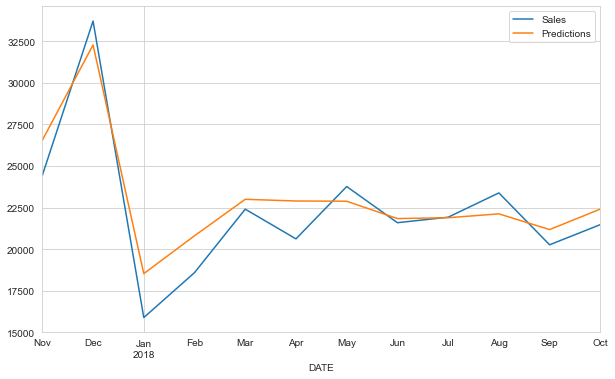

In [48]:
compare.plot()

In [49]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.8605227862311706 
mae: 1296.3404736916211 
mse: 2343584.03576038 
rmse: 1530.8768845862098


Biz burada length 12 değil de 24 veya 48 alsaydım sonuç daha kötü çıkacaktı. Çünkü forecastleri predictionlar üzerine kuruyoruz.

## Retrain and Forecasting

Test seti ayırmadan tüm veri ile modeli çalıştıracağım.

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [51]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [52]:
len(df)

334

In [53]:
len(generator)

322

In [54]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 5s 7ms/step - loss: 0.0217
Epoch 2/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0196
Epoch 3/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0195
Epoch 4/15
322/322 [==============================] - 3s 11ms/step - loss: 0.0191
Epoch 5/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0164
Epoch 6/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0164
Epoch 7/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0147
Epoch 8/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0143
Epoch 9/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0116
Epoch 10/15
322/322 [==============================] - 2s 8ms/step - loss: 0.0113
Epoch 11/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0110
Epoch 12/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0069A: 0s - loss: 0.00
Epoch 

In [55]:
scaled_full_data.shape

(334, 1)

In [56]:
scaled_full_data[-length:].shape

(12, 1)

In [57]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [58]:
forecast = scaler.inverse_transform(forecast)

In [59]:
forecast

array([[28681.14771938],
       [31468.78068638],
       [18783.93790817],
       [21260.31142902],
       [23885.76573086],
       [23725.67865562],
       [24157.00915432],
       [22839.09078884],
       [23329.01043177],
       [23693.07185221],
       [22261.06333065],
       [25238.9439683 ]])

In [60]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


Alias    Description
B        business day frequency
C        custom business day frequency
D        calendar day frequency
W        weekly frequency
M        month end frequency
SM       semi-month end frequency (15th and end of month)
BM       business month end frequency
CBM      custom business month end frequency
MS       month start frequency
SMS      semi-month start frequency (1st and 15th)
BMS      business month start frequency
CBMS     custom business month start frequency
Q        quarter end frequency
BQ       business quarter end frequency
QS       quarter start frequency
BQS      business quarter start frequency
A, Y     year end frequency
BA, BY   business year end frequency
AS, YS   year start frequency
BAS, BYS business year start frequency
BH       business hour frequency
H        hourly frequency
T, min   minutely frequency
S        secondly frequency
L, ms    milliseconds
U, us    microseconds
N        nanoseconds

Yukarıdaki forecastimi indekslemem gerekir. Bunun için aşağıdaki işlemi yapıyorum. Aşağıdaki linkte kısaltmaların aliasları yazıyor.

In [61]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [62]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [63]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [64]:
forecast_df

,Forecast
2019-11-01,28681.148
2019-12-01,31468.781
2020-01-01,18783.938
2020-02-01,21260.311
2020-03-01,23885.766
2020-04-01,23725.679
2020-05-01,24157.009
2020-06-01,22839.091
2020-07-01,23329.010
2020-08-01,23693.072


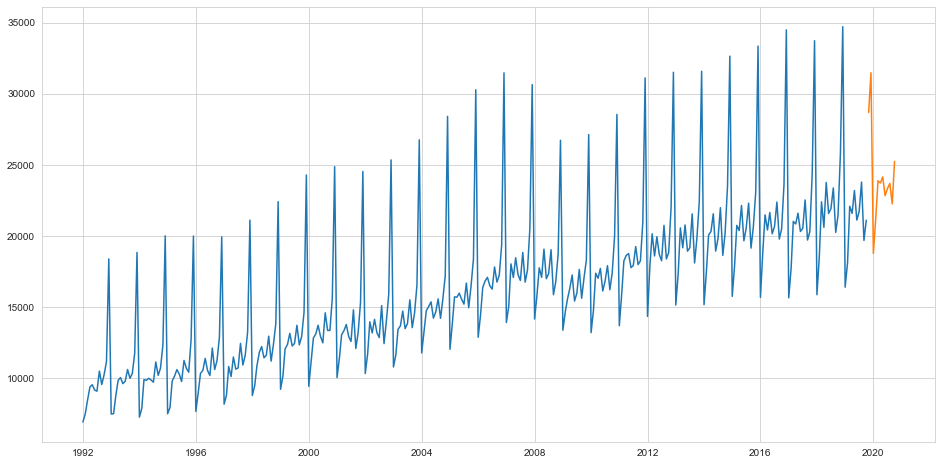

In [65]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

Aşağıdaki gibi pandas ile bunu yaparken daha büyük olan df ax atadık.

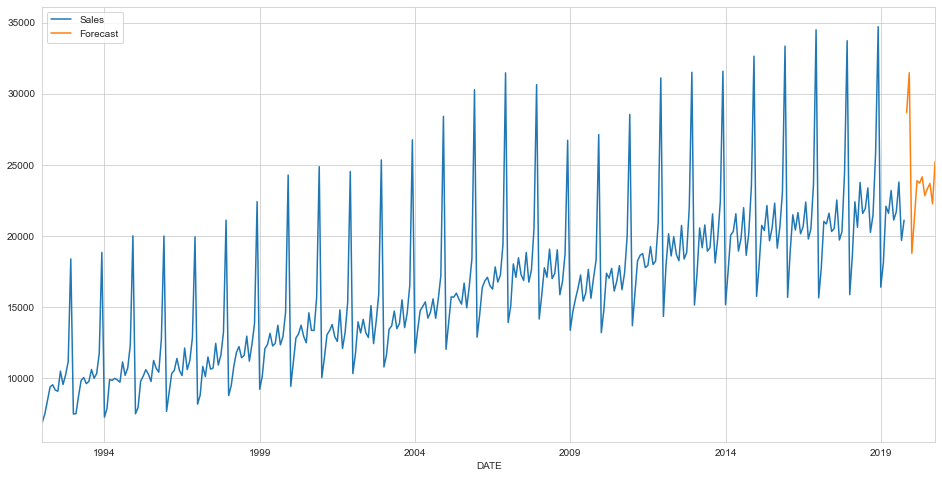

In [66]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

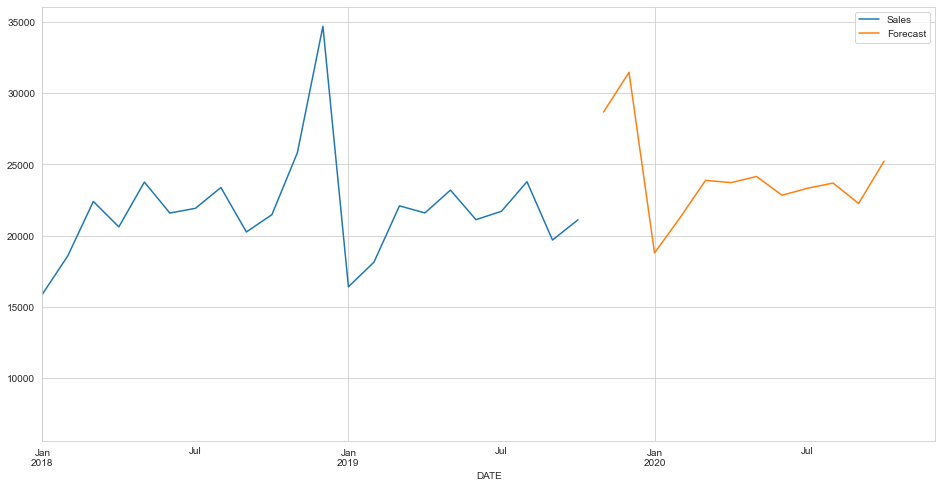

In [67]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

Aradaki boşluğu doldurmak için df leri concat ile birleştirdik. Ancak bu durumda da renk ayrımı olmadı hepsini mavi olarak gösterdi.

In [68]:
dataset_total = pd.concat((df['Sales'], forecast_df['Forecast']), axis=0)

<AxesSubplot:>

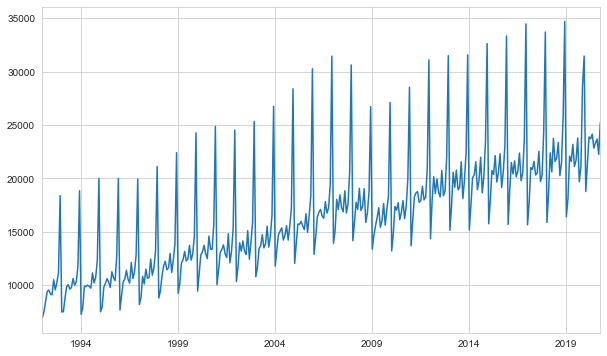

In [69]:
dataset_total.plot()

ReLu ile Tanh a göre daha iyi scorelar alabiliyoruz. Ancak bunun için birkaç kez çalıştırmak gerekebilir.

LSTM, GRU, Simple RNN, NLP nin default Tanh ancak ReLu denemekte de fayda var.

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___